# 자연어를 이용한 감성분류
  - IMDB 데이터 셋

In [ ]:
# 데이터를로드  훈련용 테스트용 데이터셋 나누기, 텍스트 데이터의 길이를 시각화해서 데이터에 대한 이해
# vocab_size = 10000 설정  , 빈도수가 높은 10000개의 단어만 사용
# 최대 길이는 500으로 제한

GRU 기반 모델 구축
  - Gate Recurent Unit  LSTM모델과 유사하나 좀도 시계열 데이터와 자연어 처리에 효과적
  - Embedding 레이어 : 단어를 임베딩 벡터로 변환
  - GRU 레이어 : 입련된 단어 시퀀스에 대해 순차적인 처리를 수행
  - Dense 레이어 : 마지막 출력은 시그모이드 함수로 0 과 1의 확률 을 출력

In [ ]:
# 필요한 라이브러리
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [ ]:
print('첫번째 훈련용 리뷰 :',X_train[0])
print('첫번째 훈련용 리뷰의 레이블 :',y_train[0])

첫번째 훈련용 리뷰 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
첫번째 훈련용 리뷰의 레이블 : 1


In [ ]:
# 실제매핑은 +3
word_to_index = imdb.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[1]]))
print(y_train[1])

<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [ ]:
# 모델 설정
embedding_dim = 100  # 임베딩 벡터의 차원
hidden_units = 128 # GRU의 은닉 상태 크기
vocab_size = 10000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 훈련 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 데이터 불러오기
max_len = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


# 훈련 실행
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.6644 - loss: 0.5941
Epoch 1: val_acc improved from -inf to 0.82460, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - acc: 0.6650 - loss: 0.5934 - val_acc: 0.8246 - val_loss: 0.4009
Epoch 2/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.8740 - loss: 0.3098
Epoch 2: val_acc improved from 0.82460 to 0.87840, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - acc: 0.8740 - loss: 0.3096 - val_acc: 0.8784 - val_loss: 0.3068
Epoch 3/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.9280 - loss: 0.1876
Epoch 3: val_acc did not improve from 0.87840
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - acc: 0.9279 - loss: 0.1877 - val_acc: 0.8720 - val_loss: 0.3316
Epoch 4/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.9553 - loss: 0.1219
Epoch 4: val_acc improved from 0.87840 to 0.88320, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - acc: 0

In [ ]:
# 저장된 모델을 load
loaded_model = load_model('best_model.keras')
test_accuracy = loaded_model.evaluate(X_test, y_test)
print(f'테스트 정확도: loss:{test_accuracy[0]:.4f}  accuracy : {test_accuracy[1]:.4f}'  )

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - acc: 0.8744 - loss: 0.3449
테스트 정확도: loss:0.3352  accuracy : 0.8757


문장예측

In [ ]:
def sentiment_predict(new_sentence):
  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
  encoded = []

  # 띄어쓰기 단위 토큰화 후 정수 인코딩
  for word in new_sentence.split():
    try :
      # 단어 집합의 크기를 10,000으로 제한.
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
      # 10,000 이상의 숫자는 <unk> 토큰으로 변환.
        encoded.append(2)
    # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=max_len)
  score = float(loaded_model.predict(pad_sequence)[0]) # 예측

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [ ]:
test_input = "This movie was so unfocused and uninteresting"
sentiment_predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
96.14% 확률로 긍정 리뷰입니다.


<ipython-input-162-31c6a723762c>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_sequence)[0]) # 예측


# 나이브 베이즈 분류기
  - 1. 베이즈 정리를 기반으로 한 확률적 분류 모델
      - 스펨메일 필터링, 감성분석, 뉴스 분류
      - 베이즈 정리

      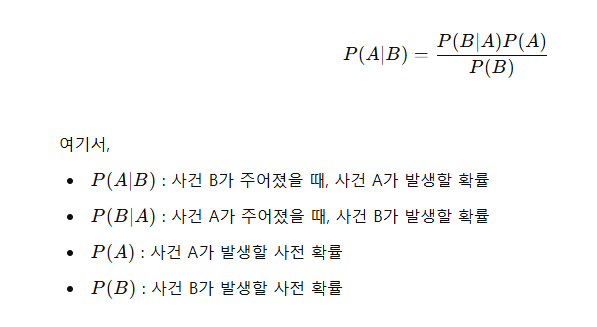

- 나이브 베이즈 분류 가정
  - 각 단어는 서로 독립적이라고 가정 ("Naive" 가정)
  - 문서안에서 단어 순서는 무시, 단어의 등장 빈도만 고려( Bag of Words ,Bow)
- 나이브 베이즈를 이용한 스펨 필터링
  - 'me free lottery'  스펨
  - 'you free scholarship'   정상


In [1]:
# 데이터 로딩
from sklearn.datasets import fetch_20newsgroups
newsdata = fetch_20newsgroups(subset='train')
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [7]:
# 텍스트 전처리 및 벡터화
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# BoW 생성
vectorizer = CountVectorizer()
X_train_counts =  vectorizer.fit_transform(newsdata.data)

# TF-IDF 변환
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# 다항 나이브 베이즈 모델  생성 학습
clf = MultinomialNB()
clf.fit(X_train_tfidf, newsdata.target)

MultinomialNB()

list

In [10]:
#  테스트  데이터 평가
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
X_test_counts = vectorizer.transform(newsdata_test.data)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

predicted = clf.predict(X_test_tfidf)
print(f"정확도: {accuracy_score(newsdata_test.target, predicted):.4f}")

정확도: 0.7739


In [16]:
# 이메일 셈플을 적용해서 스펨여부 확인
text = '''
We just received your resume and would like to thank you for your interest in
working at Google. This email confirms that your application has been submitted
for an open position.

Our staffing team will carefully assess your qualifications for the role(s) you
selected and others that may be a fit. Should there be a suitable match, we
will be sure to get in touch with you.

Click on the attached file to review your submitted application.

Have fun and thanks again for applying to Google!

Google Staffing
'''

# 벡터로 변환
X_sample_counts =  vectorizer.transform([text])
X_sample_tfidf = tfidf_transformer.transform(X_sample_counts)

# 스팸 여부 예측
predicted = clf.predict(X_sample_tfidf)
newsdata.target_names[predicted[0]]


'sci.crypt'

In [17]:
newsdata.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']